In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
# default_exp pipeline_classifier

In [ ]:
# export
import shutil
from os import path,listdir
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf

# Pipeline 
> The pipeline of text binary classifier for job offer email responses 

The dataset of email responses is loaded from a csv file. The data is classified as 'positive' or 'negative' using Tensorflow `tf.estimator` module.

In [ ]:
#hide
#Shut down logging except Error
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Data Processing

We have three steps in the data processing pipeline:
- load data -->  train-test split  -->  TF input functions

The loading and train-test split is done using the Pandas library. The conversion from a dataframe to a TF function is  necessary. 

In [ ]:
# export
def load_and_split_data(src_file, frac=0.85,random_state=None):
    df = pd.read_csv(src_file)
    train = df.sample(
        frac=frac, random_state=random_state
    )  #random state is a seed value
    test = df.drop(train.index).sample(random_state=random_state,frac=1.0)
    #examples = test.sample(5)
    return df, {'train': train, 'test': test}#, 'example': examples}

The Tensorflow input functions for train, test and example datasets are created with the help of v1 tf.estimator library

In [ ]:
# export
def tf_input_fn(df, shuffle=False, **args):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
        df, df["sentiment"], shuffle=shuffle, **args
    )

def train_input_fs(**args):
    return {
        name: tf_input_fn(df, shuffle=True, num_epochs=None)
        for name, df in args.items()
    }

def predict_input_fs(**args):
    return {
        name: tf_input_fn(df)  for name, df in args.items()
    }

**Load and split the dataset**

In [ ]:
dat, dfs = load_and_split_data(src_file='../data/interim/payloads.csv')

Percentage of the positive and negative sentiments

In [ ]:
df=dat
'sentiment: {pos: %s, neg: %s}' % ((df.sentiment ==0).sum() /df.shape[0], (df.sentiment ==1).sum() /df.shape[0])

'sentiment: {pos: 0.20110192837465565, neg: 0.7988980716253443}'

Sample of the train dataset

In [ ]:
dfs['train'].sample(2)

,payload,sentiment
104,"first, i want to thank you for the offer to wo...",0
105,although you have been most encouraging in out...,0


**Load Tensorflow input functions**

In [ ]:
train_input_fn = train_input_fs(train = dfs['train'])
predict_input_fn =  predict_input_fs(**dfs)

## Set up the Model

***Feature columns***

From TF-Hub [feature column](https://github.com/tensorflow/hub/blob/master/docs/api_docs/python/hub/text_embedding_column.md)
we use [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1). Some important facts are:

* The module takes **a batch of sentences in a 1-D tensor of strings** as input.
* The module is responsible for **preprocessing of sentences** (e.g. removal of punctuation and splitting on spaces).
* The module works with any input (e.g. **nnlm-en-dim128** hashes words not present in vocabulary into ~20.000 buckets).

In [ ]:
#export
def embedded_text_feature_column_f(module_spec="https://tfhub.dev/google/nnlm-en-dim128/1"):
    return hub.text_embedding_column(
        key="payload", module_spec=module_spec
    )

Load the embedded text feature column. If it's called it for the first time, it may take time to download it (it weights around 500 MB)

In [ ]:
embedded_text_feature_column = embedded_text_feature_column_f()

***Premade Estimators***

For classification, we use a premade [DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier)

In [ ]:
# export
def load_estimator(
    embedded_text_feature_column, estimator=tf.estimator.DNNClassifier,model_dir = None
):
    return estimator(
        model_dir = model_dir,
        hidden_units=[500, 100],
        feature_columns=[embedded_text_feature_column],
        n_classes=2,
        optimizer=tf.keras.optimizers.Adagrad(lr=0.003)
    )

In [ ]:
estimator = load_estimator(embedded_text_feature_column)

The estimator is stored in a temporary file and will be erased unless explicitly exported it (see `export_estimator` function).

## Train, Evaluate and Predict

 Train the estimator for a reasonable amount of steps.  
 Training for 5,000 steps means 640,000 training examples with the default
 batch size (128).   
 This is roughly equivalent to 640,000/363 ~ 1700 epochs since the training dataset
 contains 363 examples.

In [ ]:
#export
def train(estimator, train_input_fn,steps=5000):
    result = {}
    for name,input_fn in train_input_fn.items():
        result[name] = estimator.train(input_fn=input_fn, steps=steps)
    return result

In [ ]:
train(estimator,train_input_fn,steps=5000)

{'train': <tensorflow_estimator.python.estimator.canned.dnn.DNNClassifierV2 at 0x7fd39f3e2550>}

The F1 score is not included in `tf.estimator.evaluate`. The function `f1_score`, calculates the F1 score from the precision and recall. The function `evaluate` adds to  `tf.estimator.evaluate` the  `f1_score` and is acting over the input functions.

In [ ]:
# export
def f1_score(estimations):
    precision =  estimations['precision']
    recall = estimations['recall']
    return 2 * precision * recall / (precision + recall)

In [ ]:
# export
def evaluate(estimator, **args:tf_input_fn):
    results = {}
    for name,input_fn in args.items():
        results[name] = estimator.evaluate(input_fn=input_fn)
        results[name]['f1_score'] = f1_score(results[name])
    return results

The `predict` function, takes a dataframe of payloads in give the corresponding prediction

In [ ]:
#export
def predict(estimator, df_examples):

    def predict_from_input_fn(estimator, **input_fns):
        res = {}
        for name, input_fn in input_fns.items():
            res[name] = np.array(
                [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]
            )
        return res

    return predict_from_input_fn(
        estimator, **predict_input_fs(examples=df_examples)
    )['examples']

Evaluate:

In [ ]:
eval_results = evaluate(estimator,**predict_input_fn)

In [ ]:
print("Training set accuracy: {accuracy}".format(**eval_results['train']))
print("Test set accuracy: {accuracy}".format(**eval_results['test']))

Training set accuracy: 0.9935275316238403
Test set accuracy: 0.9444444179534912


Predict:

In [ ]:
predict(estimator, dfs['test'].sample(5)) 

array([1, 1, 1, 1, 1])

It is desirable a function that takes directly a string and assesses if it represents a  positive or negative sentiment. The function `sentiment` covers this role.

In [ ]:
# export
def sentiment(estimator, doc):
    ex_df = pd.DataFrame([{'payload':doc,'sentiment':0}])
    pred = ["negative", "positive"][predict(estimator,ex_df)[0]]
    return pred #doc + '\n --> \n' + pred

In [ ]:
example_str = ''' thank you for offering me the position of Merchandiser with Thomas Ltd.
i am thankful to accept this job offer and look ahead to starting my career with your company
on June 27, 2000.'''
sentiment(estimator,example_str)

'positive'

***Confusion matrix***  
The function `plot_confusion_matrix` plots the corresponding confusion matrix over dataframe and its corresponding TF function. Confusion matrix helps  to understand the distribution of misclassifications.

In [ ]:
# export
def plot_confusion_matrix(df_data, estimator, input_fn, header):
    def get_predictions(estimator, input_fn):
        return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

    LABELS = ["negative", "positive"]

    # Create a confusion matrix on dataframe data.
    cm = tf.math.confusion_matrix(
        df_data["sentiment"], get_predictions(estimator, input_fn)
    )

    # Normalize the confusion matrix so that each row sums to 1.
    cm = tf.cast(cm, dtype=tf.float32)
    cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS)
    plt.title(header)
    plt.xlabel("Predicted")
    plt.ylabel("True")

The Confusion Matrix on the Train Set

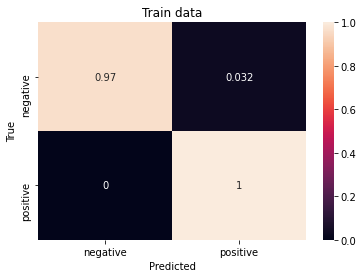

In [ ]:
plot_confusion_matrix(dfs['train'],estimator,predict_input_fn['train'],header='Train data')

The Confusion Matrix on the Test Set

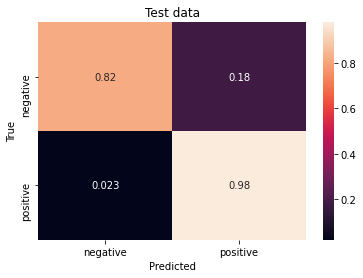

In [ ]:
plot_confusion_matrix(dfs['test'],estimator,predict_input_fn['test'],header='Test data')

## Save and Load an Estimator

The  `export_estimator` function copy the directory of the estimador given in `estimator.model_dir` to a *dst_model*.

In [ ]:
# export
def export_estimator(estimator,dst_estimator):
    shutil.copytree(estimator.model_dir, dst_estimator)

Load the saved estimator using `load_model` and check that the evaluation results are up to date with latest check point:

In [ ]:
with TemporaryDirectory() as tmpdirname:
    tmp_dir = path.join(tmpdirname,'tmp')
    export_estimator(estimator,dst_estimator = tmp_dir)
    loaded_estimator_results = evaluate(load_estimator(embedded_text_feature_column,model_dir=tmp_dir),**predict_input_fn)

In [ ]:
assert loaded_estimator_results == eval_results

In [ ]:
del dfs,estimator, eval_results, embedded_text_feature_column, loaded_estimator_results

In [ ]:
# export
class Pipeline:
    '''Class that implements the previous functions as their methods and has a new addtional method `pipeline`.'''
    def __init__(self, src_file, estimator_dir=None, frac=0.85):
        self.frac = 0.8
        self.estimator_dir = estimator_dir
        self.random_state = None
        self.data, self.dfs = load_and_split_data(
            src_file=src_file, random_state=self.random_state, frac=self.frac
        )
        self.train_steps = 5000
        self.module_spec = "https://tfhub.dev/google/nnlm-en-dim128/1"

    def input_fns(self):
        self.input = {}
        self.input['train'] = train_input_fs(train=self.dfs['train'])
        self.input['predict'] = predict_input_fs(**self.dfs)

    def load_estimator(self):
        self.embedded_text_feature_column = embedded_text_feature_column_f(
            module_spec=self.module_spec
        )
        self.estimator = load_estimator(
            self.embedded_text_feature_column, model_dir=self.estimator_dir
        )

    def train(self):
        train(self.estimator, self.input['train'], steps=self.train_steps)

    def evaluate(self):
        self.evaluation = evaluate(self.estimator, **self.input['predict'])

    def plot_confusion_matrix(self, label):
        plot_confusion_matrix(
            self.dfs[label],
            self.estimator,
            self.input['predict'][label],
            header=label + ' data'
        )

    def export_estimator(self, dst_dir):
        try:
            _ = self.estimator
        except:
            self.load_estimator()
        export_estimator(self.estimator, dst_dir)

    def predict(self, df_examples):
        '''Predict from dataframe'''
        return predict(self.estimator,df_examples)

    def sentiment(self, doc):
        return sentiment(self.estimator,doc)

    def pipeline(self):
        ''' The pipeline flow is:
            input_fns --> load_estimator --> train --> evaluate
        '''
        self.input_fns()
        self.load_estimator()
        self.train()
        self.evaluate()

The `pipeline` calls the functions that prepares the input data, trains the model and stores the results of the evaluation

In [ ]:

from nbdev.showdoc import *
show_doc(Pipeline.pipeline)

<h4 id="Pipeline.pipeline" class="doc_header"><code>Pipeline.pipeline</code><a href="__main__.py#L55" class="source_link" style="float:right">[source]</a></h4>

> <code>Pipeline.pipeline</code>()

The pipeline flow is:
input_fns --> load_estimator --> train --> evaluate

**Check that all methods are implemented correctly**

First call the pipeline method

In [ ]:
pipeline = Pipeline(src_file= '../data/interim/payloads.csv')
pipeline.pipeline()

The resulting evaluation is stored in `pipeline.evaluation`

In [ ]:
pipeline.evaluation.keys()

dict_keys(['train', 'test'])

In [ ]:
pipeline.evaluation['test']    

{'accuracy': 0.8630137,
 'accuracy_baseline': 0.79452056,
 'auc': 0.9597701,
 'auc_precision_recall': 0.9897229,
 'average_loss': 0.21598883,
 'label/mean': 0.79452056,
 'loss': 0.21598883,
 'precision': 0.9,
 'prediction/mean': 0.8155946,
 'recall': 0.9310345,
 'global_step': 5000,
 'f1_score': 0.9152542656778231}

The confusion matrix for train set

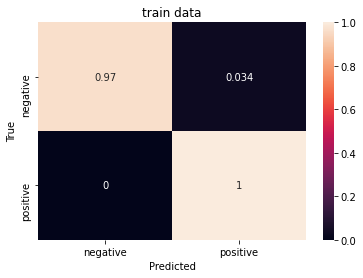

In [ ]:
pipeline.plot_confusion_matrix('train')

The confustion matrix for test set

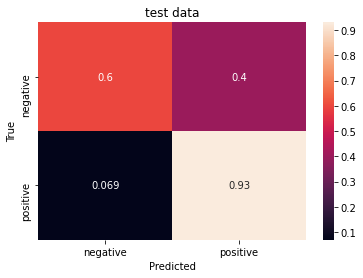

In [ ]:
pipeline.plot_confusion_matrix('test')

Check that the `export_estimator` is rightly copying the model files

In [ ]:
with TemporaryDirectory() as tmpdirname:
    tmp_dir = path.join(tmpdirname,'tmp')
    pipeline.export_estimator(tmp_dir)
    
    assert listdir(tmp_dir) == listdir(pipeline.estimator.model_dir)

Predict examples in 0 1 format

In [ ]:
pipeline.predict(dat.sample(1))

array([1])

Predict from string

In [ ]:
doc_str='''thank you very much for offering me the opportunity to work at Norris, Wilson and Kelley as Clinical embryologist.\nafter much deliberation, i will not be accepting the position,
as it isn’t the right fit for my long-term career goals.\ni sincerely appreciate the offer and give you
my best wishes in finding a suitable candidate for the position.\ni wish you and the company well 
in all future endeavours.'''
print(pipeline.sentiment(doc_str))

negative


In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_merge_datasets.ipynb.
Converted 01_pipeline_classifier.ipynb.
Converted 02_k_fold_validation.ipynb.
Converted index.ipynb.
